 # <font color="red"> MTH8408 : Méthodes d'optimisation et contrôle optimal </font>

 ## <font color="orange"> Laboratoire 3: Optimisation sans contraintes et méthodes itératives </font>


Travail réalisé par Julien Pallage

Matricule: 2012861

17 février 2024

In [1]:
using Pkg
Pkg.activate(".") #Accède au fichier Project.toml
Pkg.add("LDLFactorizations")
Pkg.add("OptimizationProblems")
Pkg.add("Plots")
Pkg.add("SolverCore")
Pkg.add("LinearOperators")
Pkg.add("BenchmarkTools")
Pkg.add("OptimizationProblems")
Pkg.add("NLPModelsJuMP")
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Documents/code/MTH8408-Hiv24/lab3_JP`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


Status `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  [54578032] ADNLPModels v0.7.0
  [ecbce9bc] BenchmarkProfiles v0.4.4
  [6e4b80f9] BenchmarkTools v1.4.0
  [7073ff75] IJulia v1.24.2
  [10dff2fc] JSOSolvers v0.11.0
  [40e66cde] LDLFactorizations v0.10.1
  [5c8ed15e] LinearOperators v2.6.0
  [a4795742] NLPModels v0.20.0
  [792afdf1] NLPModelsJuMP v0.12.5
  [5049e819] OptimizationProblems v0.7.3
  [91a5bcdd] Plots v1.40.1
  [581a75fa] SolverBenchmark v0.6.0
  [ff4d7338] SolverCore v0.3.7
  [37e2e46d] LinearAlgebra
  [de0858da] Printf


In [2]:
using BenchmarkTools, SolverCore, LinearOperators
using JSOSolvers, NLPModels, OptimizationProblems # 
using ADNLPModels
using SolverBenchmark
using LinearAlgebra, NLPModels, Printf
using OptimizationProblems.ADNLPProblems

###  <font color="lightgreen"> Exercice 1: Méthode quasi-Newton L-BFGS </font>

Compléter votre implémentation de la méthode L-BFGS et illustrer son utilisation sur un des problèmes sans contraintes de la collection OptimizationProblems.jl.

---
---

SOLUTION:

In [3]:
"""
Function that implements an armijo line search
Obligatory inputs: xk, dk, fk, gk, slope, nlp.
Outputs: armijo parameter t, new fk.
"""
function armijo(xk, dk, fk, gk, slope, nlp :: AbstractNLPModel; τ1 = 1.0e-4, t_update = 1.5)
    t = 1.0
    fk_new = obj(nlp, xk + dk) # t = 1.0
    while fk_new > fk + τ1 * t * slope
      t /= t_update
      fk_new = obj(nlp, xk + t * dk)
    end
    return t, fk_new
end

"""
Function that solves an unconstrained nlp object with a limited bfgs algorithm
Obligatory inputs: nlp object,
Outputs: Execution Stats
"""
function limited_bfgs(nlp      :: AbstractNLPModel;
    x        :: AbstractVector = nlp.meta.x0,
    atol     :: Real = √eps(eltype(x)), 
    rtol     :: Real = √eps(eltype(x)),
    max_eval :: Int = -1,
    max_time :: Float64 = 30.0,
    f_min    :: Float64 = -1.0e16,
    verbose  :: Bool = true,
    mem      :: Int = 5)
  start_time = time()
  elapsed_time = 0.0

  T = eltype(x)
  n = Int(nlp.meta.nvar)

  xt = zeros(T, n)
  ∇ft = zeros(T, n)

  f = obj(nlp, x)
  ∇f = grad(nlp, x)
  #################################################
  H = InverseLBFGSOperator(n;mem=mem) ### Use InverseLBFGSOperator instead of I ###
  #################################################

  ∇fNorm = norm(∇f) #nrm2(n, ∇f)
  ϵ = atol + rtol * ∇fNorm
  iter = 0

  @info log_header([:iter, :f, :dual, :slope, :bk], [Int, T, T, T, T],
  hdr_override=Dict(:f=>"f(x)", :dual=>"‖∇f‖", :slope=>"∇fᵀd"))

  optimal = ∇fNorm ≤ ϵ
  unbdd = f ≤ f_min
  tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
  stalled = false
  status = :unknown

  while !(optimal || tired || stalled || unbdd)

    #################################################
    d = H*∇f ### Compute d
    d *= -1
    #################################################
    slope = dot(d, ∇f)
    if slope ≥ 0
      @error "not a descent direction" slope
      status = :not_desc
      stalled = true
    continue
    end

    # Perform improved Armijo linesearch.
    t, ft = armijo(x, d, f, ∇f, slope, nlp)

    @info log_row(Any[iter, f, ∇fNorm, slope, t])

    # Update L-BFGS approximation.
    xt = x + t * d
    ∇ft = grad(nlp, xt) # grad!(nlp, xt, ∇ft)
    #################################################
    st = xt - x
    yt = ∇ft -  ∇f
    push!(H, st, yt) ### Update H with a new st and yt
    #################################################

    # Move on.
    x = xt
    f = ft
    ∇f = ∇ft

    ∇fNorm = norm(∇f) #nrm2(n, ∇f)
    iter = iter + 1

    optimal = ∇fNorm ≤ ϵ
    unbdd = f ≤ f_min
    elapsed_time = time() - start_time
    tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
  end
  @info log_row(Any[iter, f, ∇fNorm])

  if optimal
    status = :first_order
  elseif tired
  if neval_obj(nlp) > max_eval ≥ 0
    status = :max_eval
  elseif elapsed_time > max_time
    status = :max_time
  end
  elseif unbdd
    status = :unbounded
  end

  return GenericExecutionStats(
  nlp,
  status=status,
  solution=x,
  objective=f,
  dual_feas=∇fNorm,
  iter=iter,
  elapsed_time=elapsed_time,
  )
end

limited_bfgs

Nous illustrons son utilisation et sa performance sur le problème unconstrained Tridia de la collection OptimizationProblems.jl.

In [4]:
OptimizationProblems.tridia_meta

Dict{Symbol, Any} with 17 entries:
  :has_equalities_only    => false
  :origin                 => :unknown
  :has_inequalities_only  => false
  :defined_everywhere     => missing
  :has_fixed_variables    => false
  :variable_ncon          => false
  :nvar                   => 100
  :is_feasible            => true
  :minimize               => true
  :ncon                   => 0
  :name                   => "tridia"
  :best_known_lower_bound => -Inf
  :objtype                => :other
  :best_known_upper_bound => 5049.0
  :has_bounds             => false
  :variable_nvar          => true
  :contype                => :unconstrained

In [5]:
n = 100
nlp = tridia(n=n)

stats = limited_bfgs(nlp)


┌ Info:   iter      f(x)      ‖∇f‖      ∇fᵀd        bk  
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:49
┌ Info:      0   5.0e+03   1.2e+03  -1.4e+06   7.7e-03
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75


┌ Info:      1   2.0e+03   1.6e+03  -4.8e+03   6.7e-01
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:      2   1.1e+03   1.2e+03  -1.3e+03   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:      3   4.5e+02   3.1e+02  -1.1e+02   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:      4   3.5e+02   2.3e+02  -3.2e+02   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:      5   1.7e+02   2.2e+02  -1.7e+02   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:      6   1.5e+02   4.3e+02  -1.0e+02   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:      7   8.5e+01   1.3e+02  -1.9e+01   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:      8   7.1e+01   9.2e+01  -2.1e+01   1

┌ Info:     75   1.1e-03   2.8e-01  -1.2e-04   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:     76   9.7e-04   2.4e-01  -2.5e-04   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:     77   7.9e-04   3.2e-01  -3.3e-04   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:     78   5.9e-04   5.2e-01  -4.0e-04   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:     79   4.4e-04   3.9e-01  -1.4e-04   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:     80   3.3e-04   2.0e-01  -1.2e-04   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:     81   2.5e-04   1.8e-01  -9.8e-05   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:     82   1.9e-04   2.2e-01  -1.2e-04   1

┌ Info:    149   8.2e-09   3.6e-04  -8.1e-10   6.7e-01
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:    150   8.1e-09   8.3e-04  -4.8e-10   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:    151   7.8e-09   3.1e-04  -1.6e-10   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:    152   7.7e-09   2.8e-04  -3.5e-10   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:    153   7.4e-09   3.9e-04  -5.2e-10   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:    154   7.0e-09   5.3e-04  -1.3e-09   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:    155   6.7e-09   1.2e-03  -1.0e-09   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:    156   6.0e-09   5.0e-04  -5.3e-10   1

"Execution stats: first-order stationary"

In [6]:
print(stats)

Generic Execution stats
  status: first-order stationary
  objective value: 1.2824360088337822e-11
  primal feasibility: 0.0
  dual feasibility: 1.533229397405431e-5
  solution: [0.9999965771090676  0.4999983282656731  0.24999917035173627  0.12499953412164919 ⋯ 4.3035947366902296e-10]
  iterations: 188
  elapsed time: 0.705265998840332


As we see, it took 188 iterations to converge to a local mimimaum of approximately 0.

###  <font color="lightgreen"> Exercice 2: Méthode Newton-CG </font>

Compléter votre implémentation de la méthode Newton-CG et illustrer son utilisation sur un des problèmes sans contraintes de la collection OptimizationProblems.jl.

---
---

SOLUTION:

In [7]:
"""
Function that obtains a search direction with the conjugate gradient algorithm
Inputs: Hessian and gradient
Ouput: A new direction 
"""
function cg_optim(H, ∇f)
    #setup the tolerance:
    n∇f = norm(∇f)
#####################################
    ϵk = min(0.5, sqrt(n∇f)).*n∇f # added
####################################
    n = length(∇f)
    z = zeros(n)
    r = ∇f
    d = -r
    
    j = 0
    while norm(r) ≥ ϵk && j < 3 * n
###############################################
        if dot(d, H * d) ≤ 0
            pk = (j == 0) ? - ∇f : z # added
        end
##############################################
        α =dot(r,r)./(transpose(d)*H*d) # added
##############################################        
        z += α * d
        nrr2 = dot(r, r)
        r += α * H * d
##############################################
        β  = dot(r,r)./nrr2 # added
##############################################
        d  = -r + β.*d
        j += 1
    end
    return z # or return d?
end



"""
Function that uses an armijo linesearch, with a Newton algorithm while using a conjugate gradient direction each step 
Inputs: An NLP object and other mandatory parameters.
Ouptut: Execution stats.

"""
function armijo_Newton_cg(nlp      :: AbstractNLPModel;
                          x        :: AbstractVector = nlp.meta.x0,
                          atol     :: Real = √eps(eltype(x)), 
                          rtol     :: Real = √eps(eltype(x)),
                          max_eval :: Int = -1,
                          max_time :: Float64 = 30.0,
                          f_min    :: Float64 = -1.0e16)
  start_time = time()
  elapsed_time = 0.0

  T = eltype(x)
  n = nlp.meta.nvar

  f = obj(nlp, x)
  ∇f = grad(nlp, x)
#################################################
  H = hess_op(nlp, x)#what is y? Initialize H as linear operator representing the Hessian matrix 
#################################################

  ∇fNorm = norm(∇f) #nrm2(n, ∇f)
  ϵ = atol + rtol * ∇fNorm
  iter = 0

  @info log_header([:iter, :f, :dual, :slope, :bk], [Int, T, T, T, T],
                   hdr_override=Dict(:f=>"f(x)", :dual=>"‖∇f‖", :slope=>"∇fᵀd"))

  optimal = ∇fNorm ≤ ϵ
  unbdd = f ≤ f_min
  tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
  stalled = false
  status = :unknown

  while !(optimal || tired || stalled || unbdd)
        
    d = cg_optim(H, ∇f) 
        
    slope = dot(d, ∇f)
    if slope ≥ 0
      @error "not a descent direction" slope
      status = :not_desc
      stalled = true
      continue
    end

    # Perform improved Armijo linesearch.
    t, f = armijo(x, d, f, ∇f, slope, nlp)
        
    @info log_row(Any[iter, f, ∇fNorm, slope, t])

    # Update L-BFGS approximation.
    x += t * d
    ∇f = grad(nlp, x)
#################################################
    H = hess_op(nlp, x)### Update H
#################################################

    ∇fNorm = norm(∇f) #nrm2(n, ∇f)
    iter = iter + 1

    optimal = ∇fNorm ≤ ϵ
    unbdd = f ≤ f_min
    elapsed_time = time() - start_time
    tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
  end
  @info log_row(Any[iter, f, ∇fNorm])

  if optimal
    status = :first_order
  elseif tired
    if neval_obj(nlp) > max_eval ≥ 0
      status = :max_eval
    elseif elapsed_time > max_time
      status = :max_time
    end
  elseif unbdd
        status = :unbounded
  end

  return GenericExecutionStats(nlp, status = status, solution=x, objective=f, dual_feas=∇fNorm,
                               iter=iter, elapsed_time=elapsed_time)
end

armijo_Newton_cg

Une deuxième fois, illustrons sa performance sur le problème `tridia`.

In [8]:
n = 100
nlp = tridia(n=n)
stats = armijo_Newton_cg(nlp)

┌ Info:   iter      f(x)      ‖∇f‖      ∇fᵀd        bk  
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:69
┌ Info:      0   6.3e+02   1.2e+03  -8.8e+03   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:93


┌ Info:      1   1.2e+02   5.1e+02  -1.0e+03   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:93
┌ Info:      2   2.7e+01   2.0e+02  -1.8e+02   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:93
┌ Info:      3   1.5e+01   9.7e+01  -2.3e+01   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:93
┌ Info:      4   2.2e+00   4.4e+01  -2.5e+01   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:93
┌ Info:      5   4.9e-01   1.7e+01  -3.5e+00   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:93
┌ Info:      6   2.4e-01   7.7e+00  -5.1e-01   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:93
┌ Info:      7   9.9e-02   3.8e+00  -2.8e-01   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:93
┌ Info:      8   1.4e-03   1.6e+00  -1.9e-01   1

"Execution stats: first-order stationary"

In [9]:
print(stats)

Generic Execution stats
  status: first-order stationary
  objective value: 3.37580889992935e-13
  primal feasibility: 0.0
  dual feasibility: 1.1199496148809964e-5
  solution: [0.9999999912018402  0.5000000300459599  0.2500000476635215  0.12499997802900703 ⋯ 2.570225077445835e-9]
  iterations: 15
  elapsed time: 0.3483250141143799


Ici, on remarque que ça a pris seulement 15 itérations pour converger à un minimum local de valeur similaire l'exercice 1!

###  <font color="lightgreen"> Exercice 3: Benchmark LBFGS vs Taille mémoire </font>

Comparer LBFGS avec mémoire m = 1, m = 5 et m = 20 sur une collection de problèmes sans contraintes de OptimizationProblems.jl.
Préciser combien de problèmes sont utilisés, inclure des profils de performance, et mentionner un/des problèmes qui ne sont pas résolus par l’algorithme.

---
---

SOLUTION:

In [10]:
OptimizationProblems.meta

Row,nvar,variable_nvar,ncon,variable_ncon,minimize,name,has_equalities_only,has_inequalities_only,has_bounds,has_fixed_variables,objtype,contype,best_known_lower_bound,best_known_upper_bound,is_feasible,defined_everywhere,origin
,Int64,Bool,Int64,Bool,Bool,String,Bool,Bool,Bool,Bool,Symbol,Symbol,Real,Real,Bool?,Bool?,Symbol
1,1,false,0,false,true,AMPGO02,false,false,false,false,other,unconstrained,-Inf,0.839498,true,missing,unknown
2,1,false,0,false,true,AMPGO03,false,false,false,false,other,unconstrained,-Inf,2.88961,true,missing,unknown
3,1,false,0,false,true,AMPGO04,false,false,false,false,other,unconstrained,-Inf,-2.5666,true,missing,unknown
4,1,false,0,false,true,AMPGO05,false,false,false,false,other,unconstrained,-Inf,-0.0,true,missing,unknown
5,1,false,0,false,true,AMPGO06,false,false,false,false,other,unconstrained,-Inf,3.5177e-43,true,missing,unknown
6,1,false,0,false,true,AMPGO07,false,false,false,false,other,unconstrained,-Inf,2.56475,true,missing,unknown
7,1,false,0,false,true,AMPGO08,false,false,false,false,other,unconstrained,-Inf,-2.0928,true,missing,unknown
8,1,false,0,false,true,AMPGO09,false,false,false,false,other,unconstrained,-Inf,0.921136,true,missing,unknown
9,1,false,0,false,true,AMPGO10,false,false,false,false,other,unconstrained,-Inf,-0.0,true,missing,unknown


In [26]:

ad_problems = (eval(Meta.parse(problem))()  for problem ∈ OptimizationProblems.meta[!, :name])


solvers = Dict(
  :lbfgs_5 => model -> limited_bfgs(model; mem=5),
  :lbfgs_10 => model -> limited_bfgs(model; mem=10),
  :lbfgs_20 => model -> limited_bfgs(model; mem=20),
)

stats = bmark_solvers(
  solvers, ad_problems,
  skipif=prob -> (!unconstrained(prob) || get_nvar(prob) > 50 || get_nvar(prob) < 5),
)

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:127
┌ Info:          biggs6       6       0        unbounded   4.7e-05  -3.2e+22   4.1e+22   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: catenary: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/catenary.jl:4
┌ Warning: catenary: number of variables adjusted to be greater or equal to 6
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/catenary.jl:6
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12
┌ Warning: 

┌ Info:          gauss2       8       0      first_order   5.7e-02   6.2e+02   6.2e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          gauss3       8       0         max_time   3.0e+01   6.2e+02   5.8e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:           hahn1       7       0         max_time   3.0e+01   2.7e+04   5.2e+06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          kirby2       5       0      first_order   2.4e-03   1.5e+01   5.4e+02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos1       6       0      first_order   2.8e-04   2.1e-06   4.4e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos2       6       0      first_order   3.2e-04   2.1e-06   5.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos3       6       0      first_order   3.2e-04   2.2e-06   4.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh17       5       0      first

┌ Info:        osborne1       5       0         max_time   3.0e+01   2.3e-02   3.1e-01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        osborne2      11       0      first_order   2.7e-03   2.0e-02   5.5e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        palmer1c       8       0      first_order   3.3e-01   8.4e+01   3.5e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1d       7       0      first_order   3.2e-01   1.4e+01   3.0e-01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        palmer2c       8       0      first_order   9.3e-02   2.2e+00   2.2e-01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer3c       8       0      first_order   4.4e-02   1.7e+00   8.4e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        palmer4c       8       0      first_order   7.5e-02   2.4e+00   8.4e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer5c       6       0      first_order   4.0e-04   1.1e+00   3.1e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        palmer6c       8       0      first_order   2.5e-01   4.8e-02   7.1e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer7c       8       0      first_order   2.7e-01   2.2e+00   2.8e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        palmer8c       8       0      first_order   1.4e-01   3.0e-01   8.4e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         thurber       7       0      first_order   9.9e-02   2.8e+03   1.4e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        vibrbeam       8       0      first_order   4.0e-03   4.6e+00   5.3e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          watson      31       0        unbounded   5.1e-01  -3.8e+90   8.1e+90   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:127
┌ Info:          biggs6       6       0        unbounded   3.6e-05  -3.2e+22   4.1e+22   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: catenary: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/catenary.jl:4
┌ Warning: catenary: number of variables adjusted to be greater or equal to 6
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/catenary.jl:6
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12
┌ Warning: 

┌ Info:          gauss2       8       0      first_order   4.4e-03   6.2e+02   4.3e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          gauss3       8       0      first_order   4.1e-03   6.2e+02   5.3e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:           hahn1       7       0         max_time   3.0e+01   2.7e+04   5.2e+06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          kirby2       5       0      first_order   2.7e-03   1.5e+01   5.5e+02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos1       6       0      first_order   2.5e-04   2.1e-06   5.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos2       6       0      first_order   2.6e-04   2.1e-06   3.1e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos3       6       0      first_order   2.6e-04   2.2e-06   7.1e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh17       5       0      first

┌ Info:        osborne1       5       0         max_time   3.0e+01   2.3e-02   4.1e+04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        osborne2      11       0      first_order   7.4e-04   2.0e-02   2.6e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1c       8       0      first_order   7.5e-03   8.4e+01   1.8e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1d       7       0      first_order   8.1e-03   1.4e+01   2.5e-01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer2c       8       0      first_order   4.1e-03   2.2e+00   9.1e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer3c       8       0      first

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:127
┌ Info:          biggs6       6       0        unbounded   2.8e-05  -3.2e+22   4.1e+22   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: catenary: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/catenary.jl:4
┌ Warning: catenary: number of variables adjusted to be greater or equal to 6
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/catenary.jl:6
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12
┌ Warning: 

┌ Info:          gauss2       8       0         max_time   3.0e+01   6.2e+02   2.1e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          gauss3       8       0         max_time   3.0e+01   6.2e+02   7.8e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:           hahn1       7       0         max_time   3.0e+01   2.7e+04   5.2e+06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          kirby2       5       0      first_order   2.6e-03   1.5e+01   6.1e+02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos1       6       0      first_order   2.0e-04   2.1e-06   8.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos2       6       0      first_order   2.1e-04   2.1e-06   3.9e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos3       6       0      first_order   2.5e-04   2.2e-06   8.0e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh17       5       0      first

┌ Info:        osborne1       5       0         max_time   3.0e+01   2.3e-02   1.4e+02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        osborne2      11       0      first_order   1.1e-03   2.0e-02   5.5e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1c       8       0      first_order   1.0e-02   8.4e+01   1.4e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1d       7       0      first_order   1.6e-02   1.4e+01   2.1e-01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer2c       8       0      first_order   8.0e-03   2.2e+00   8.6e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer3c       8       0      first

┌ Info:        palmer8c       8       0      first_order   5.1e-03   3.0e-01   1.3e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         thurber       7       0      first_order   2.7e-03   2.8e+03   1.2e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        vibrbeam       8       0      first_order   9.0e-04   5.3e+00   1.4e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          watson      31       0        unbounded   2.8e-03  -3.8e+90   8.1e+90   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


Dict{Symbol, DataFrames.DataFrame} with 3 entries:
  :lbfgs_5  => 25×39 DataFrame…
  :lbfgs_20 => 25×39 DataFrame…
  :lbfgs_10 => 25×39 DataFrame…

In [27]:
# this code was found as is @ https://jso.dev/OptimizationProblems.jl/dev/benchmark/

cols = [:id, :name, :nvar, :objective, :dual_feas, :neval_obj, :neval_grad, :neval_hess, :iter, :elapsed_time, :status]
header = Dict(
  :nvar => "n",
  :objective => "f(x)",
  :dual_feas => "‖∇f(x)‖",
  :neval_obj => "# f",
  :neval_grad => "# ∇f",
  :neval_hess => "# ∇²f",
  :elapsed_time => "t",
)
for solver ∈ keys(solvers)
    pretty_stats(stats[solver][!, cols], hdr_override=header)
  end

┌────────┬──────────┬────────┬───────────┬───────────┬──────────┬─────────┬────────┬─────────┬───────────┬─────────────┐
│     id │     name │      n │      f(x) │   ‖∇f(x)‖ │      # f │    # ∇f │  # ∇²f │    iter │         t │      status │
├────────┼──────────┼────────┼───────────┼───────────┼──────────┼─────────┼────────┼─────────┼───────────┼─────────────┤
│     50 │   biggs6 │      6 │ -3.17e+22 │  4.12e+22 │        3 │       3 │      0 │       2 │  4.70e-05 │   unbounded │
│    104 │     enso │      9 │  3.94e+02 │  4.04e-07 │       49 │      38 │      0 │      37 │  1.47e-03 │ first_order │
│    112 │   gauss1 │      8 │  6.58e+02 │  6.51e-03 │  7200927 │  187119 │      0 │  187118 │  3.00e+01 │    max_time │
│    113 │   gauss2 │      8 │  6.24e+02 │  6.24e-03 │     6110 │    3339 │      0 │    3338 │  5.69e-02 │ first_order │
│    114 │   gauss3 │      8 │  6.22e+02 │  5.84e-03 │  7832976 │  187971 │      0 │  187970 │  3.00e+01 │    max_time │
│    120 │    hahn1 │      7 │  

┌ Warning: some measures are zero; shifting all by one
└ @ BenchmarkProfiles /home/julien/.julia/packages/BenchmarkProfiles/KnjdY/src/performance_profiles.jl:16
┌ Warning: some measures are zero; shifting all by one
└ @ BenchmarkProfiles /home/julien/.julia/packages/BenchmarkProfiles/KnjdY/src/performance_profiles.jl:16


┌ Warning: some measures are zero; shifting all by one
└ @ BenchmarkProfiles /home/julien/.julia/packages/BenchmarkProfiles/KnjdY/src/performance_profiles.jl:16
┌ Warning: some measures are zero; shifting all by one
└ @ BenchmarkProfiles /home/julien/.julia/packages/BenchmarkProfiles/KnjdY/src/performance_profiles.jl:16


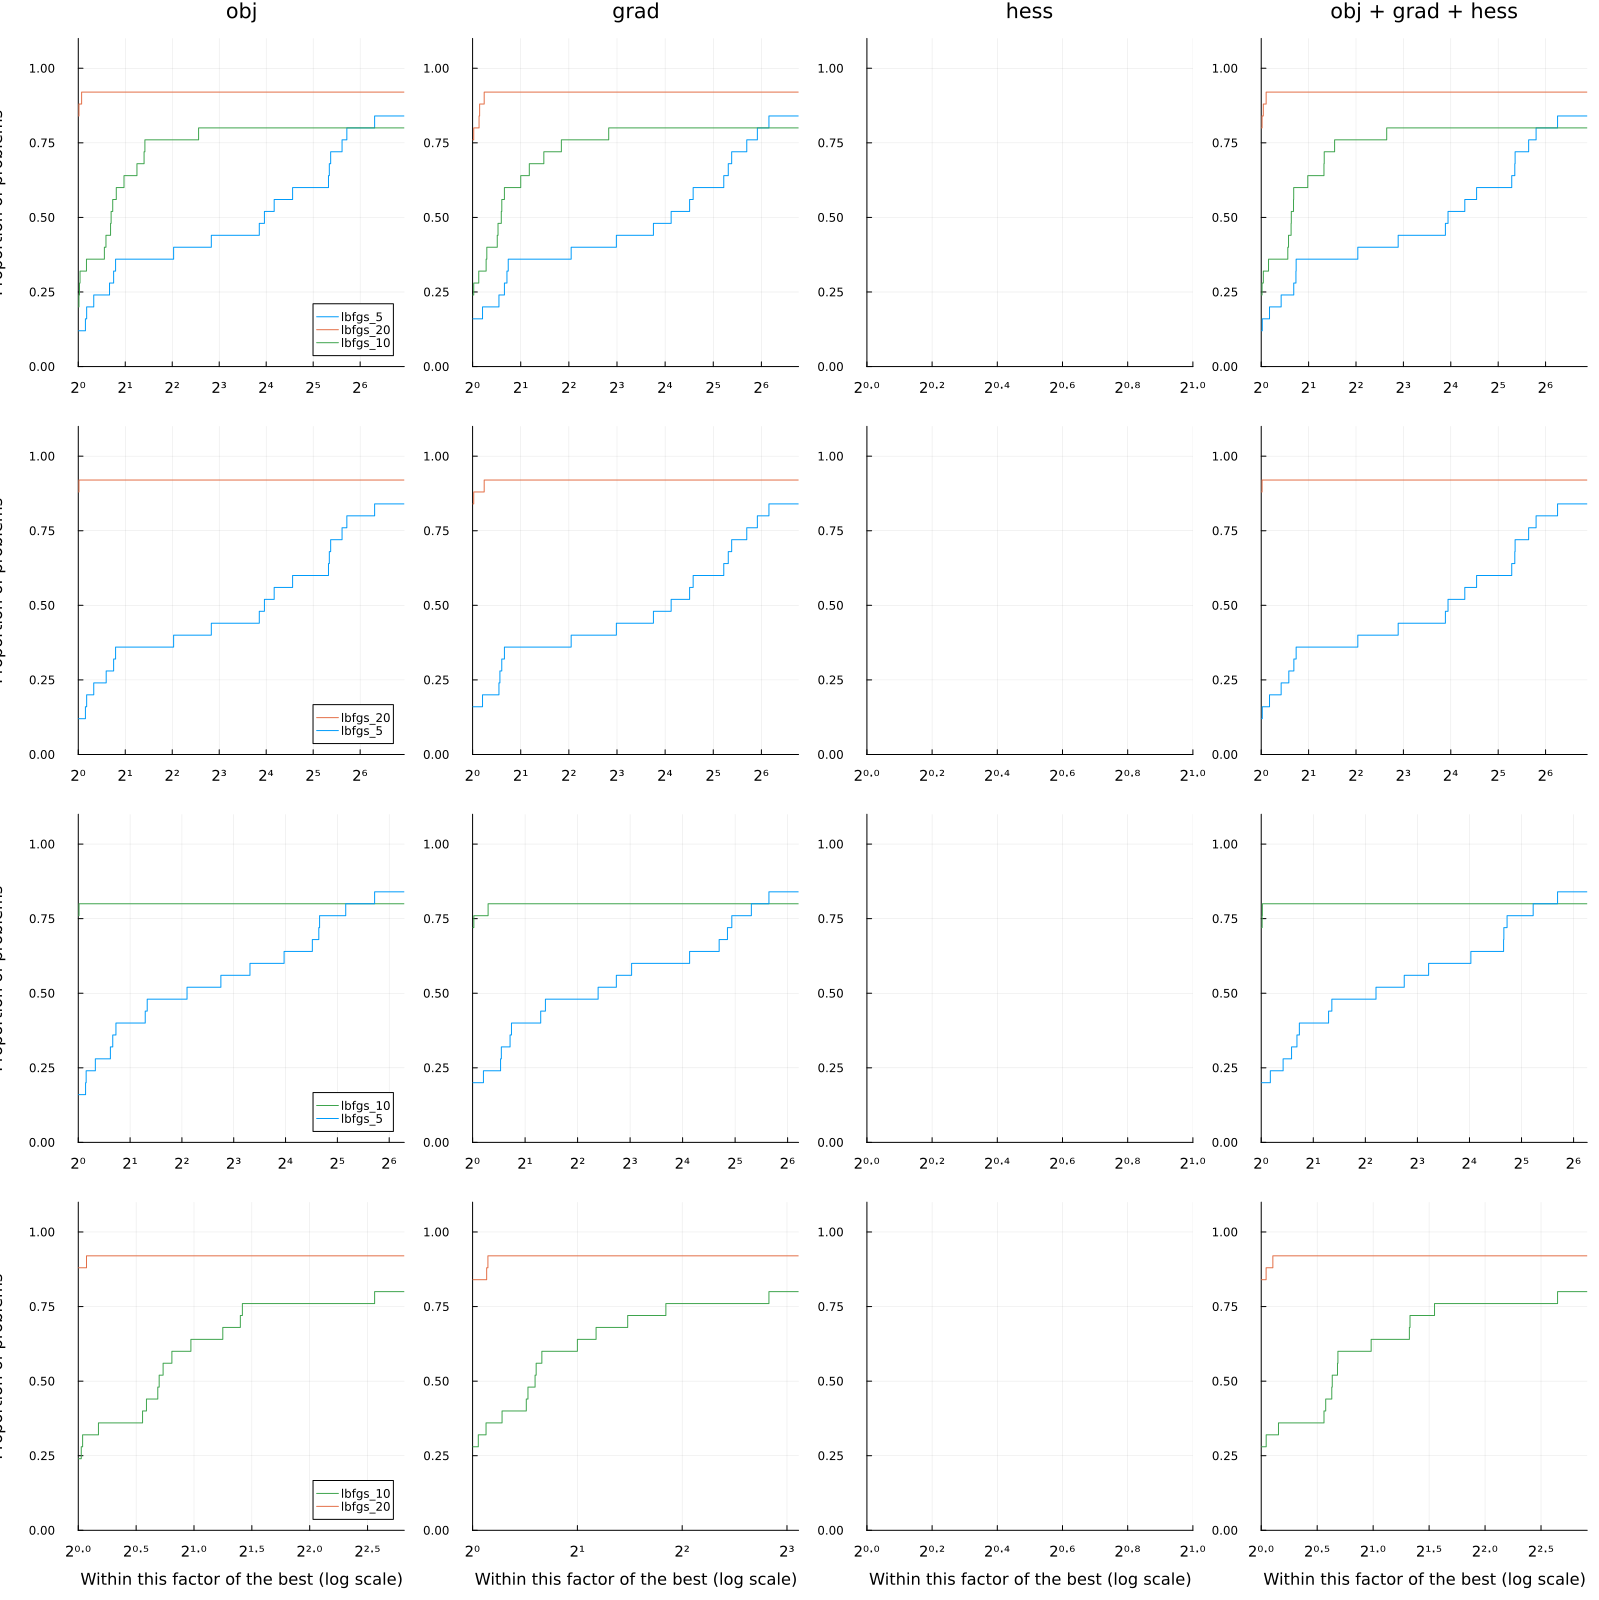

In [28]:
# this code was found partially @ https://jso.dev/OptimizationProblems.jl/dev/benchmark/

first_order(df) = df.status .== :first_order
unbounded(df) = df.status .== :unbounded
solved(df) = first_order(df) .| unbounded(df)
costnames = ["obj","grad","hess", "obj + grad + hess"]
costs = [
  df -> .!solved(df) .* Inf .+ df.neval_obj,
  df -> .!solved(df) .* Inf .+ df.neval_grad,
  df -> .!solved(df) .* Inf .+ df.neval_hess,
  df -> .!solved(df) .* Inf .+ df.neval_obj .+ df.neval_grad .+ df.neval_hess,
]

using Plots
gr()

profile_solvers(stats, costs, costnames)

Analyse des résultats:

###  <font color="lightgreen"> Exercice 4: Benchmark LBFGS vs Newton-CG </font>

Comparer la meilleure variante obtenue (justifier) à l’Exercice 3 et comparer cette méthode à Newton-CG sur la même collection de problèmes sans contraintes de OptimizationProblems.jl. Préciser combien de problèmes sont utilisés, inclure des profils de performance, et mentionner un/des problèmes qui ne sont pas résolus par l’algorithme.

---
---

SOLUTION:

In [29]:

ad_problems = (eval(Meta.parse(problem))()  for problem ∈ OptimizationProblems.meta[!, :name])


solvers = Dict(
  :newton_cg => model -> armijo_Newton_cg(model),
  :lbfgs_10 => model -> limited_bfgs(model; mem=10),
)

stats = bmark_solvers(
  solvers, ad_problems,
  skipif=prob -> (!unconstrained(prob) || get_nvar(prob) > 50 || get_nvar(prob) < 5),
)

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:127
┌ Info:          biggs6       6       0      first_order   3.7e-04  -1.0e+01   8.0e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: catenary: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/catenary.jl:4
┌ Warning: catenary: number of variables adjusted to be greater or equal to 6
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/catenary.jl:6
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12
┌ Warning: 

┌ Info:        vibrbeam       8       0      first_order   1.1e-03   1.6e-01   2.2e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          watson      31       0         not_desc   6.0e-01   1.6e+00   2.9e+01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:127
┌ Info:          biggs6       6       0        unbounded   4.5e-05  -3.2e+22   4.1e+22   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: catenary: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/catenary.jl:4
┌ Warning: catenary: number of variables adjusted to be greater or equal to 6
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/catenary.jl:6
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12
┌ Warning: 

┌ Info:          gauss2       8       0         max_time   3.0e+01   6.2e+02   2.1e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          gauss3       8       0         max_time   3.0e+01   6.2e+02   7.8e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:           hahn1       7       0         max_time   3.0e+01   2.7e+04   5.2e+06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          kirby2       5       0      first_order   2.7e-03   1.5e+01   6.1e+02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos1       6       0      first_order   2.3e-04   2.1e-06   8.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos2       6       0      first_order   2.3e-04   2.1e-06   3.9e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos3       6       0      first_order   2.5e-04   2.2e-06   8.0e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh17       5       0      first

┌ Info:        osborne1       5       0         max_time   3.0e+01   2.3e-02   1.4e+02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        osborne2      11       0      first_order   1.1e-03   2.0e-02   5.5e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1c       8       0      first_order   9.9e-03   8.4e+01   1.4e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1d       7       0      first_order   1.6e-02   1.4e+01   2.1e-01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer2c       8       0      first_order   8.1e-03   2.2e+00   8.6e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer3c       8       0      first

┌ Info:        palmer8c       8       0      first_order   4.6e-03   3.0e-01   1.3e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         thurber       7       0      first_order   2.7e-03   2.8e+03   1.2e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        vibrbeam       8       0      first_order   9.0e-04   5.3e+00   1.4e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          watson      31       0        unbounded   2.8e-03  -3.8e+90   8.1e+90   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


Dict{Symbol, DataFrames.DataFrame} with 2 entries:
  :newton_cg => 25×39 DataFrame…
  :lbfgs_10  => 25×39 DataFrame…

In [30]:
# this code was found as is @ https://jso.dev/OptimizationProblems.jl/dev/benchmark/

cols = [:id, :name, :nvar, :objective, :dual_feas, :neval_obj, :neval_grad, :neval_hess, :iter, :elapsed_time, :status]
header = Dict(
  :nvar => "n",
  :objective => "f(x)",
  :dual_feas => "‖∇f(x)‖",
  :neval_obj => "# f",
  :neval_grad => "# ∇f",
  :neval_hess => "# ∇²f",
  :elapsed_time => "t",
)
for solver ∈ keys(solvers)
    pretty_stats(stats[solver][!, cols], hdr_override=header)
  end

┌────────┬──────────┬────────┬───────────┬───────────┬────────┬────────┬────────┬────────┬───────────┬─────────────┐
│     id │     name │      n │      f(x) │   ‖∇f(x)‖ │    # f │   # ∇f │  # ∇²f │   iter │         t │      status │
├────────┼──────────┼────────┼───────────┼───────────┼────────┼────────┼────────┼────────┼───────────┼─────────────┤
│     50 │   biggs6 │      6 │ -1.01e+01 │  8.01e-08 │     21 │     21 │      0 │     20 │  3.73e-04 │ first_order │
│    104 │     enso │      9 │  4.99e+02 │  2.99e+01 │      3 │      3 │      0 │      2 │  8.53e-04 │    not_desc │
│    112 │   gauss1 │      8 │  6.58e+02 │  5.90e-04 │     18 │     18 │      0 │     17 │  4.60e-03 │ first_order │
│    113 │   gauss2 │      8 │  6.24e+02 │  4.54e-03 │     21 │     21 │      0 │     20 │  5.57e-03 │ first_order │
│    114 │   gauss3 │      8 │  6.22e+02 │  5.82e-06 │     27 │     27 │      0 │     26 │  8.67e-03 │ first_order │
│    120 │    hahn1 │      7 │  5.35e+03 │  2.16e+06 │     23 │ 

┌ Warning: some measures are zero; shifting all by one
└ @ BenchmarkProfiles /home/julien/.julia/packages/BenchmarkProfiles/KnjdY/src/performance_profiles.jl:16


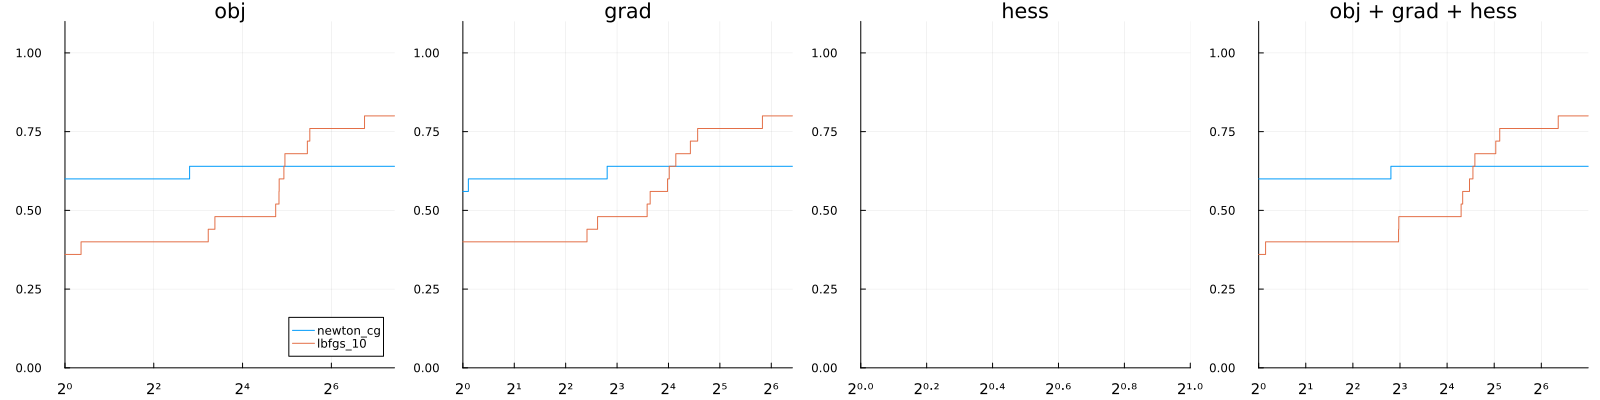

In [31]:
# this code was found partially @ https://jso.dev/OptimizationProblems.jl/dev/benchmark/

first_order(df) = df.status .== :first_order
unbounded(df) = df.status .== :unbounded
solved(df) = first_order(df) .| unbounded(df)
costnames = ["obj","grad","hess", "obj + grad + hess"]
costs = [
  df -> .!solved(df) .* Inf .+ df.neval_obj,
  df -> .!solved(df) .* Inf .+ df.neval_grad,
  df -> .!solved(df) .* Inf .+ df.neval_hess,
  df -> .!solved(df) .* Inf .+ df.neval_obj .+ df.neval_grad .+ df.neval_hess,
]

using Plots
gr()

profile_solvers(stats, costs, costnames)